In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2
import torchvision.datasets as tds
from torchvision.transforms import Lambda
import torchvision.transforms.functional as torchvisionF
from lovely_tensors import monkey_patch
monkey_patch()
import torch
from src.utils import XILUtils

device = XILUtils.define_device()
num_classes = 2

transform_func_device = Lambda(lambda i: torchvisionF.to_tensor(i).to(device=device))
ds_train = tds.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transform_func_device,
)

ds_test = tds.MNIST(
    root="data/",
    train=False,
    download=True,
    transform=transform_func_device,
)

train_dataset_length = -1

labels = [0, 8]
train_indices = [i for i, (_, label) in enumerate(ds_train) if label in labels][:train_dataset_length]
test_indices = [i for i, (_, label) in enumerate(ds_test) if label in labels]
ds_train = torch.utils.data.Subset(ds_train, train_indices)
ds_test = torch.utils.data.Subset(ds_test, test_indices)

# Set target_transform attribute
target_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float, device=device).scatter_(0, torch.tensor(0 if y == 0 else 1, device=device), value=1))
ds_train.dataset.target_transform = target_transform
ds_test.dataset.target_transform = target_transform

In [2]:
from torch.utils.data import DataLoader
tr = ds_train.dataset.target_transform
print(f"{ds_train.dataset.targets=}")


batch_size = 64

# create dataloader
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

train_dl_iterator = iter(train_dataloader)
test_dl_iterator = iter(test_dataloader)



ds_train.dataset.targets=tensor[60000] i64 0.5Mb x∈[0, 9] μ=4.454 σ=2.889


In [3]:
curr_batch = next(train_dl_iterator)
x_it, t_it = curr_batch

In [4]:
from src.experiments.cnn import CNNTwoConv

In [5]:
from pathlib import Path
model = CNNTwoConv(num_classes=2, device=device)
DIR = Path("08_MNIST_output/")
model.load_state_dict(torch.load(DIR / "confounded_ds_model.pth", weights_only=True))
model.eval()

CNNTwoConv(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)

In [6]:
with torch.no_grad():
    pred_it = model(x_it)

In [7]:
from pytorch_grad_cam import GradCAM
from src.guided_backprop import GuidedBackpropReLUModel

def guided_gradcam_explain(x_batch, model, device, target_layers):
    gb_model = GuidedBackpropReLUModel(model=model, device=device)
    
    model.eval()

    # Generate GradCAM
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = torch.tensor(cam(input_tensor=x_batch, targets=None, aug_smooth=False, eigen_smooth=False), device=device)
        gb_model_out = gb_model(x_batch, target_category=None)[:, 0, :, :]
        grayscale_cam *= gb_model_out
    
    return grayscale_cam
    

In [8]:
target_layers = [model[3]]
grayscale_explanation = guided_gradcam_explain(x_it, model, device, target_layers=target_layers)
grayscale_explanation = XILUtils.minmax_normalize_tensor(grayscale_explanation)


/Users/zlochinus/Desktop/uni/bakalarka/xil-research-modification/src/utils.py:291: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:361.)
  denom[denom == 0] = 1.0


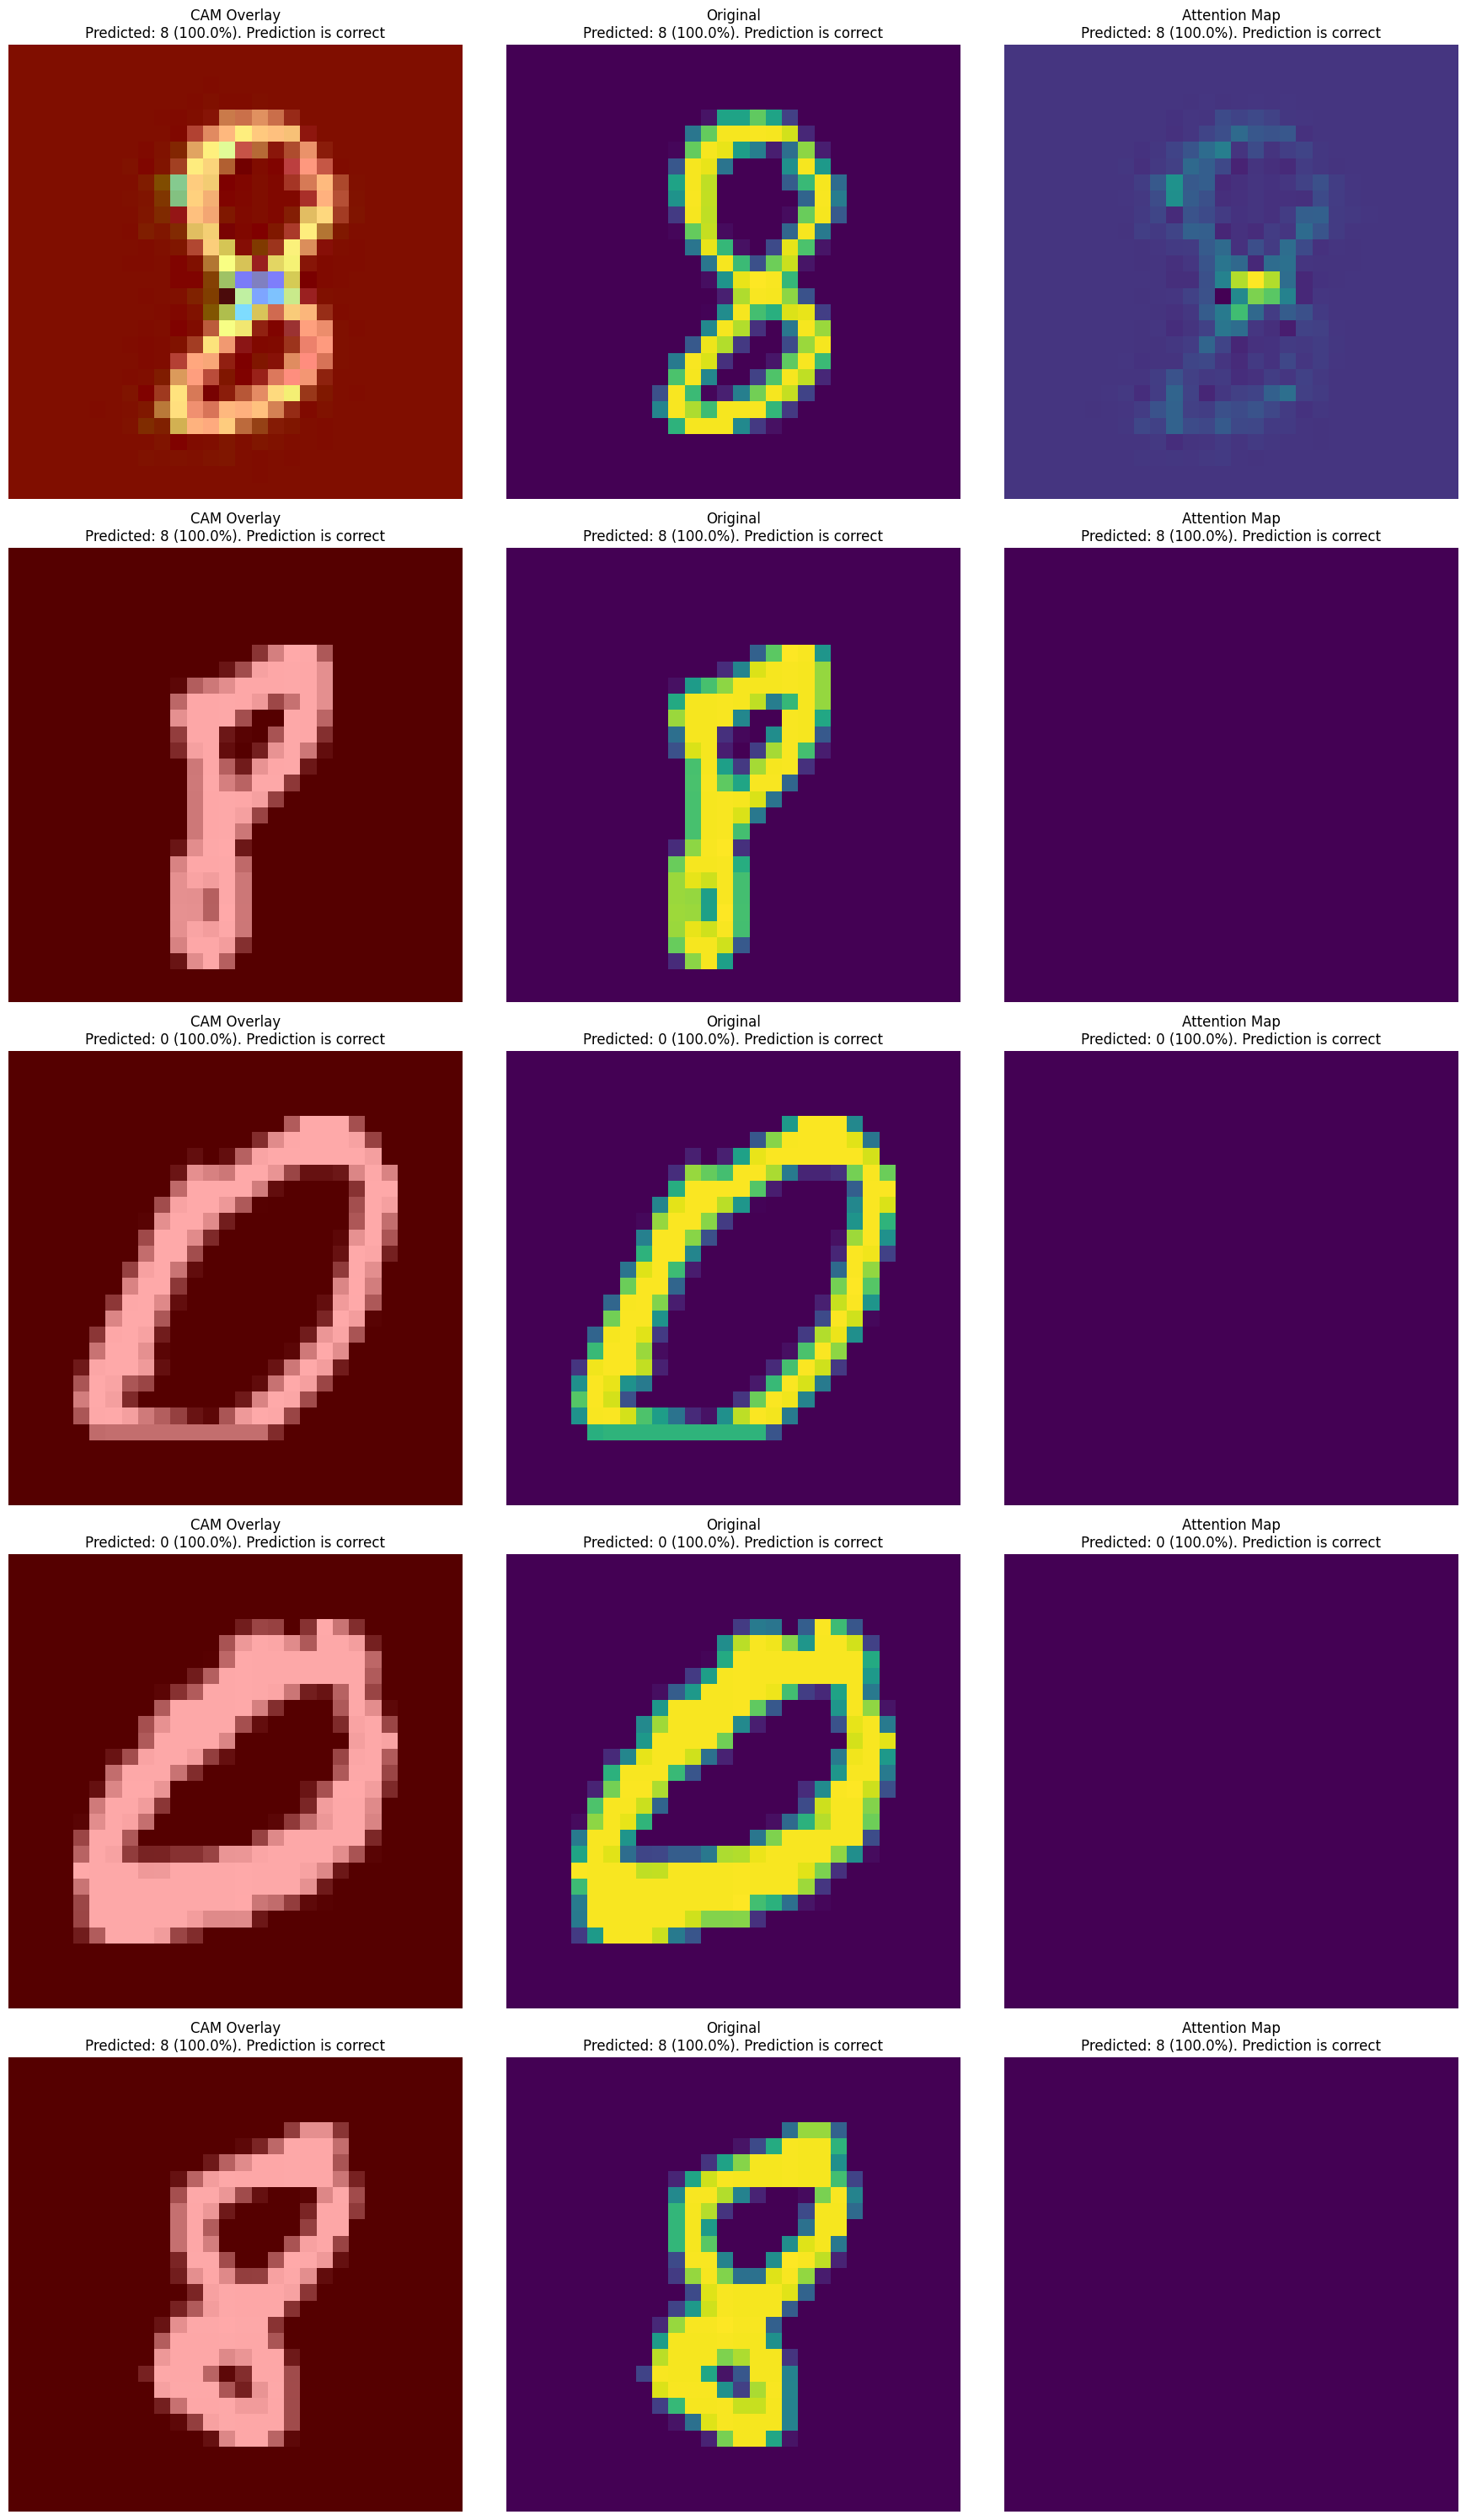

In [9]:
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

n_examples = 5
labels = [0, 8]

images = x_it.detach().cpu().numpy()
grayscale_maps = grayscale_explanation.cpu().numpy()
cam_images = []
for i in range(images.shape[0]):
    cam_images.append(show_cam_on_image(images[i].transpose((1, 2, 0)), grayscale_maps[i], use_rgb=False, image_weight=0.5))
predictions = pred_it.argmax(dim=1).cpu()
certainties = pred_it.max(dim=1).values.cpu() * 100
is_correct = (predictions == t_it.argmax(dim=1).cpu()).cpu()

XILUtils.plot_grad_cam(dict(
    images=images[:, 0, :, :], cam_images=cam_images, grayscale_maps=grayscale_maps, predictions=predictions,
                    certainties=certainties, is_correct=is_correct
),
labels,
n_examples,
plt)

## Confounding Dataset


In [10]:
def get_bottom_right_corner(image):
    # Remove the channel dimension
    tensor_2d = image.squeeze(0)
    # Find the indices where the tensor has non-zero values
    non_zero_indices = torch.nonzero(tensor_2d)
    # Get the maximum x, y indices
    max_x, max_y = non_zero_indices.max(dim=0).values
    return max_x.item(), max_y.item()

def write_dot_on_image(image, dot_sizes: torch.Size, padding=1):
    corner_x, corner_y = get_bottom_right_corner(image)
    binary_mask = torch.zeros_like(image)

    # Calculate the starting position of the dot outside the bounding box
    start_x = min(image.shape[2] - dot_sizes[1], corner_x + 1 + padding)
    start_y = min(image.shape[1] - dot_sizes[0], corner_y + 1 + padding)

    # Calculate the ending position of the dot
    end_x = min(image.shape[2], start_x + dot_sizes[1])
    end_y = min(image.shape[1], start_y + dot_sizes[0])

    # Draw the dot on the image
    image[0, start_y:end_y, start_x:end_x] = 1
    binary_mask[0, start_y:end_y, start_x:end_x] = 1

    return image, binary_mask


In [11]:
from src.rrr_dataset import RRRDataset
import random

inputs = []
targets = []
binary_masks = []

label_of_interest = torch.tensor((0, 1)) # eight
dot_sizes = [torch.Size((x, y)) for x in range(2, 3) for y in range (2, 3)]

for X, y in ds_train:
    if all(y.cpu() == label_of_interest):
        dot_size = random.choice(dot_sizes)
        input, binary_mask = write_dot_on_image(X, dot_size, padding=0)
        inputs.append(input)
        binary_masks.append(binary_mask)
    else:
        inputs.append(X)
        binary_masks.append(torch.zeros_like(X))

    targets.append(y)

misleading_ds_train = RRRDataset(torch.stack(inputs), torch.stack(targets), torch.stack(binary_masks))

# TODO: save misleading dataset into file for further upload. Do the same with transformed MNIST dataset

/var/folders/9b/rkxr4tx941l76qtgtn679kth0000gn/T/ipykernel_66654/465511660.py:7: UserWarning: MPS: no support for int64 for min_max_out, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:657.)
  max_x, max_y = non_zero_indices.max(dim=0).values


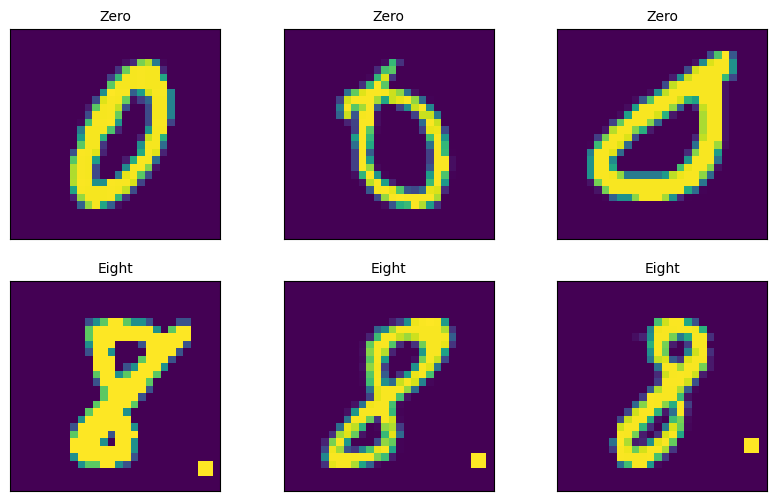

In [12]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
# fig.subplots_adjust(wspace=0, hspace=0)

# Show 3 instances for each of the 2 labels
label_translation = dict(zero=torch.tensor((1, 0), device=device), eight=torch.tensor((0, 1), device=device))
zeros = []
eights = []
example_dataloader = torch.utils.data.DataLoader(misleading_ds_train, batch_size=1, shuffle=True)
for i, (X, y, _) in enumerate(example_dataloader):
    X = torch.flatten(X, 0, 2)
    if all(y[0] == label_translation["zero"]) and len(zeros) != 3:
        zeros.append(X)
    elif all(y[0] == label_translation["eight"]) and len(eights) != 3:
        eights.append(X)

    if len(zeros) == 3 and len(eights) == 3:
        break

for i, X in enumerate(zeros):
    ax_list[0][i].imshow(X.cpu(), cmap='viridis')
    ax_list[0][i].set_title("Zero", fontsize=10, color='black')
    ax_list[0][i].set_xticks([])
    ax_list[0][i].set_yticks([])
    # ax_list[0][i].set_facecolor('black')

for i, X in enumerate(eights):
    ax_list[1][i].imshow(X.cpu(), cmap='viridis')
    ax_list[1][i].set_title("Eight", fontsize=10, color='black')
    ax_list[1][i].set_xticks([])
    ax_list[1][i].set_yticks([])



In [13]:
from src.caipi import RandomStrategy, to_counter_examples_2d_pic
def show_binary_masks(strat, is_substitution_strategy=False):
    # Show the binary masks
    original_pics = []
    titles_1 = []
    binary_masks = []
    titles_2 = []
    caipi = []
    titles_3 = []
    example_dataloader = torch.utils.data.DataLoader(misleading_ds_train, batch_size=1, shuffle=False)
    n_examples = 5
    for i, (x, y, R) in enumerate(example_dataloader):
        if all(y[0] == label_translation["zero"]):
            continue
        elif all(y[0] == label_translation["eight"]) and len(eights) != n_examples:
            prediction = model(x)
            prediction_correct = prediction.argmax() == 1
            prediction_certainty = prediction.max() * 100
            
            original_pics.append(x.cpu().view(28, 28))
            binary_masks.append(R.cpu().view(28, 28))
            if is_substitution_strategy:
                caipi_ce = to_counter_examples_2d_pic(strat, x, R.to(dtype=torch.bool), 1, target=y)[0]
            else:
                caipi_ce = to_counter_examples_2d_pic(strat, x, R.to(dtype=torch.bool), 1)[0]
                
            caipi.append(caipi_ce.cpu().view(28, 28))
            
            titles_1.append(f"Original\nPred: {prediction.argmax()}\nCertainty: {prediction_certainty:.2f}%\nCorrect: {prediction_correct}")
            titles_2.append("Binary Mask")
            titles_3.append("CAIPI")

        if len(original_pics) == n_examples:
            break
    columns = (original_pics, binary_masks, caipi)
    titles = (titles_1, titles_2, titles_3)
    XILUtils.plot_three_columns(plt, columns, n_examples, titles)

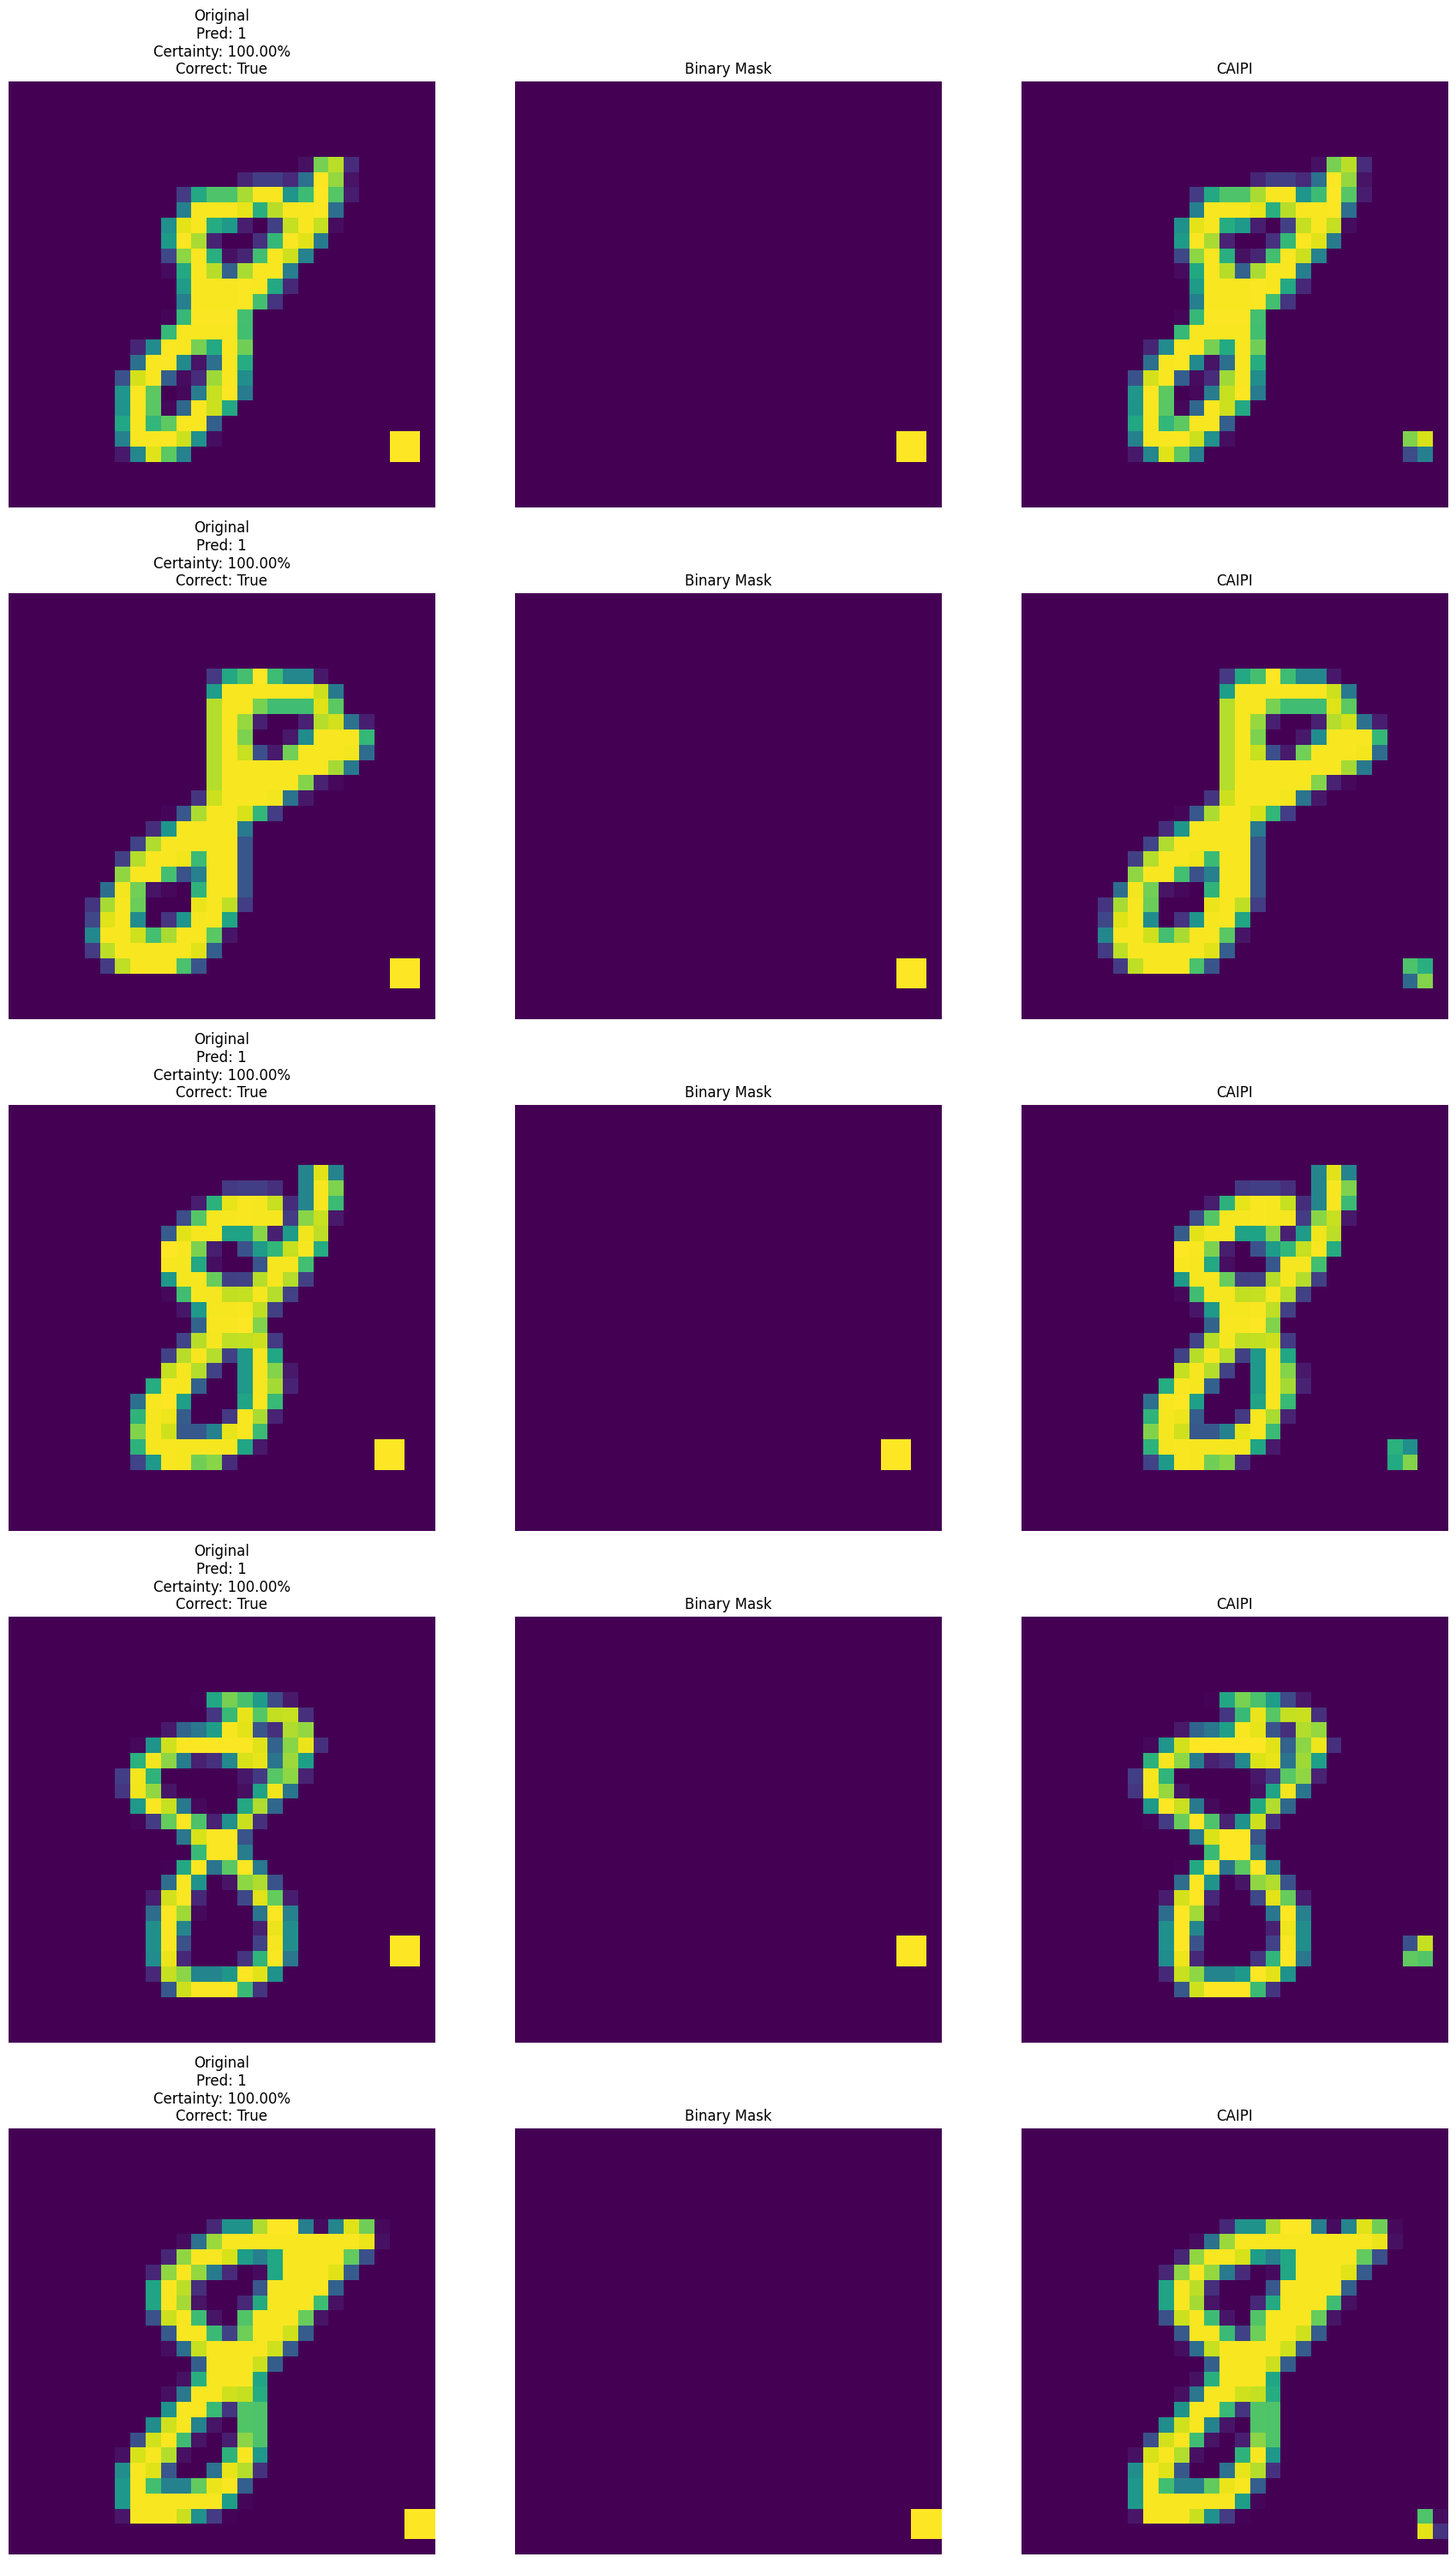

In [14]:

strategy = RandomStrategy(0., 1., torch.float32)
show_binary_masks(strategy)


### Substitution Strategy

In [15]:
from src.caipi import SubstitutionStrategy
dl = DataLoader(misleading_ds_train, batch_size=len(misleading_ds_train), shuffle=False)
inputs, targets, binary_masks = next(iter(dl))
substitution_strategy = SubstitutionStrategy(inputs, targets)

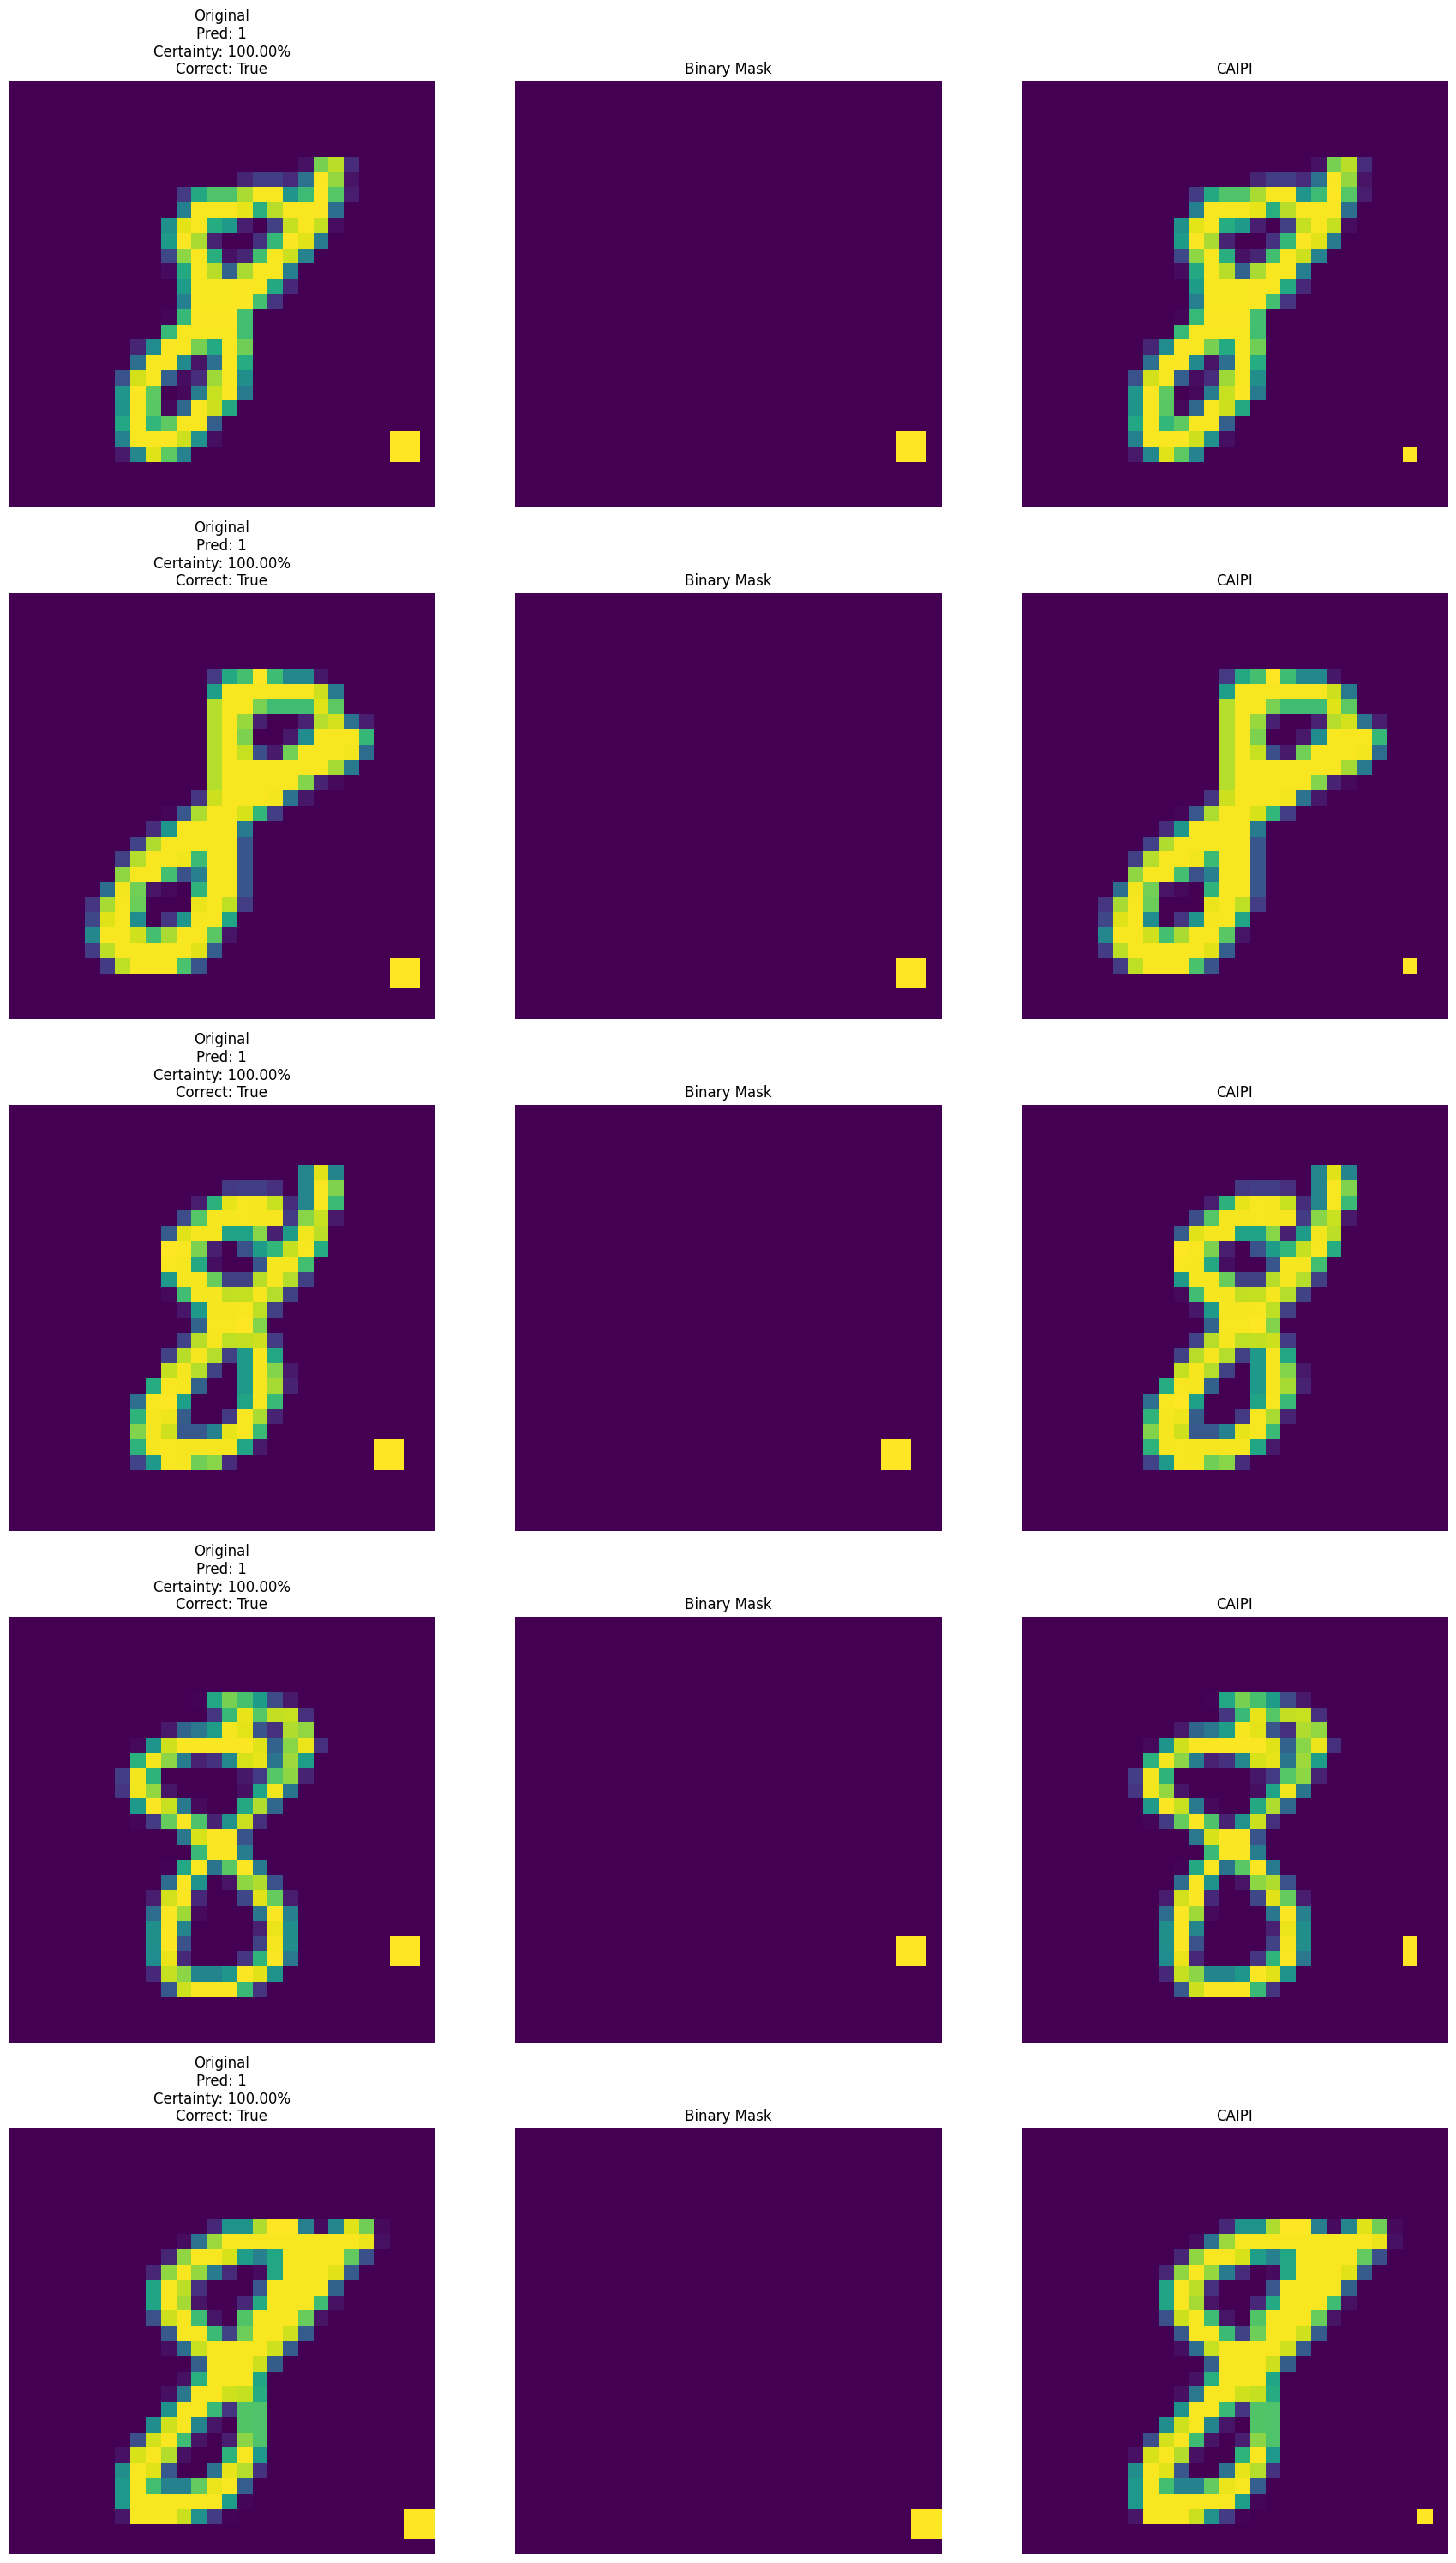

In [16]:
show_binary_masks(substitution_strategy, is_substitution_strategy=True)

### Alternative Value strategy

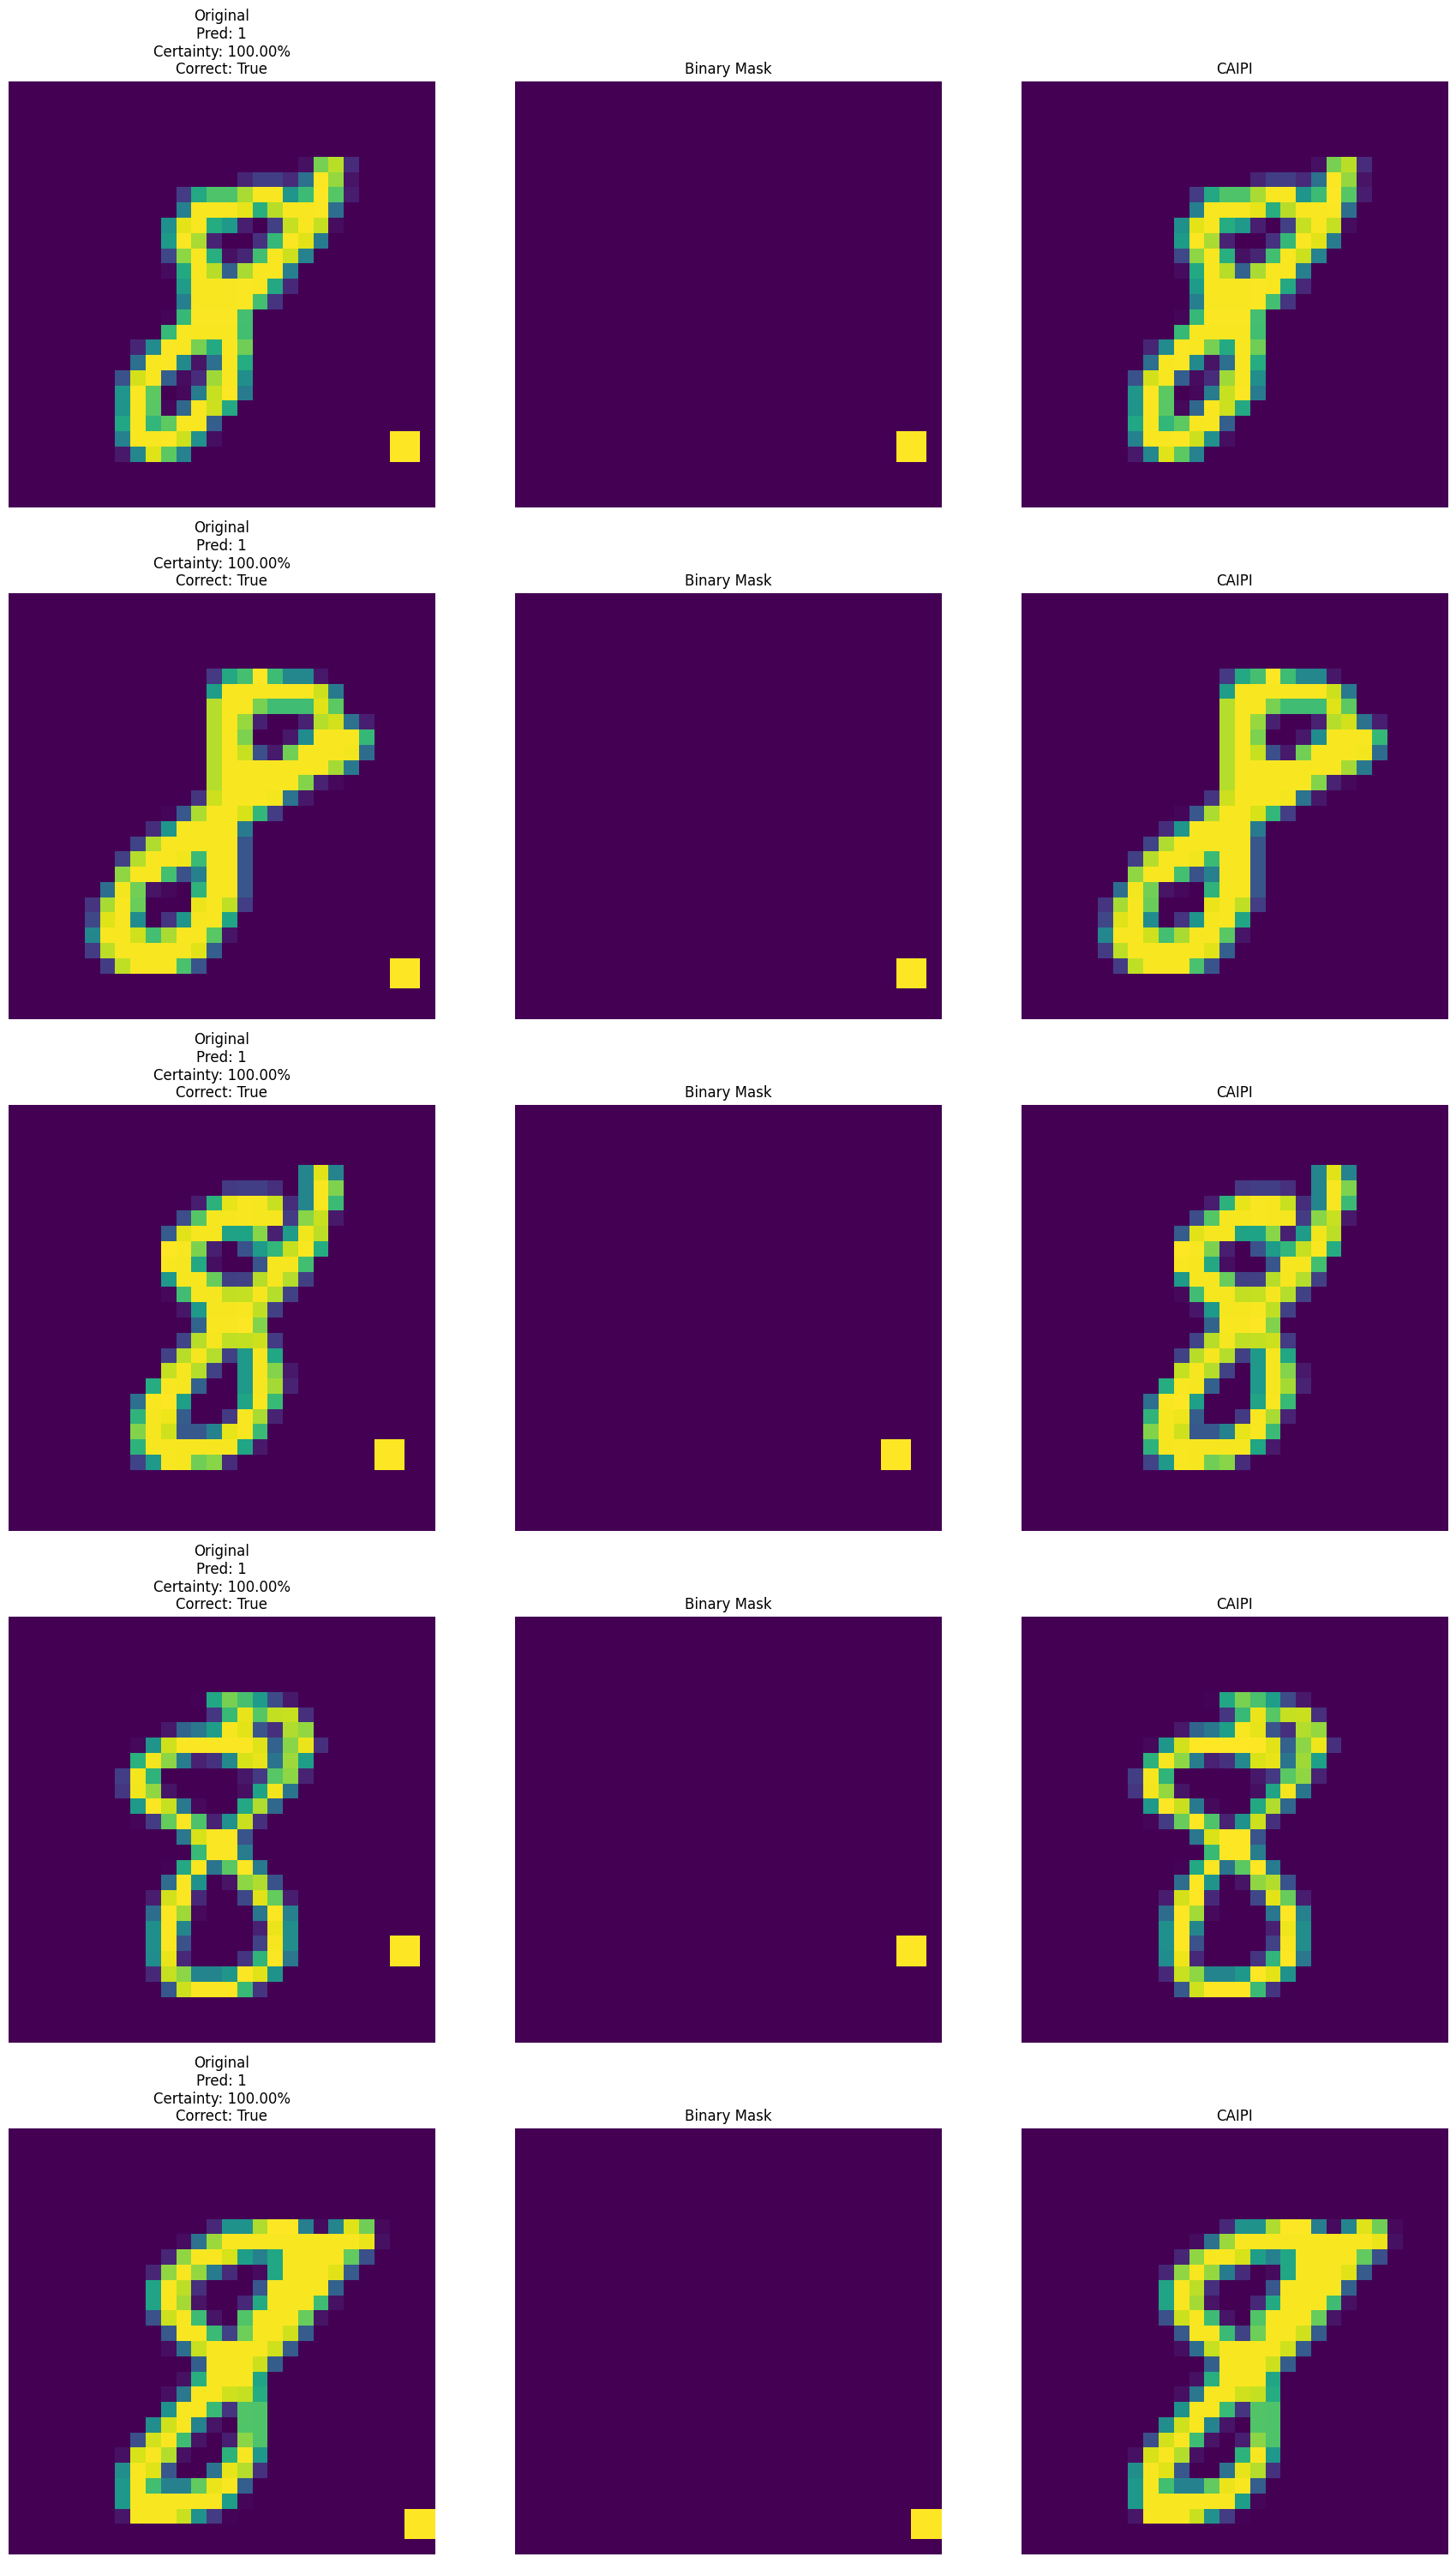

In [17]:
from src.caipi import AlternativeValueStrategy
image_shape = torch.Size((1, 1, 28, 28))
alt_strategy = AlternativeValueStrategy(torch.zeros(image_shape, device=device), torch.Size((1, 1, 28, 28)))

show_binary_masks(alt_strategy)

## Training model with bad performance on non-confounded dataset

In [18]:
import torch.nn.functional as F
def train(model, train_dataloader, optimizer, loss_fn, verbose=True):
    model.train()
    if verbose:
        print("\ntraining...")
    interval = len(train_dataloader) // 10
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        pred = model(x_batch)
        loss_value = loss_fn(pred, y_batch)
        loss_value.backward()
        optimizer.step()
        if verbose and i * batch_size % interval == 0:
            print(f"Batch {i * batch_size}/{len(train_dataloader.dataset)}: Loss = {loss_value.item():.4f}")

def evaluate(model, test_dataloader, loss_fn, verbose=True):
    if verbose:
        print("\ncomputing score...")
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for x_batch, y_batch in test_dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            total += y_batch.size(0)
            test_loss += loss_fn(pred, y_batch).item()
            correct += (F.one_hot(pred.argmax(dim=1), num_classes=num_classes) == y_batch).sum().item() / num_classes
            assert correct % 1 == 0
    
    return correct / total, test_loss / len(test_dataloader)
            
def train_evaluate(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs=1, verbose=True):
    training_dictionary = {
        "accuracies": [],
        "losses": [],
    }
    for epoch in range(num_epochs):
        if verbose:
            print(f"Epoch {epoch + 1}\n" + 20 * "-")


        # train loop 
        train(model, train_dataloader, optimizer, loss_fn, verbose)

        # Evaluate the model
        correct_ratio, avg_test_loss = evaluate(model, test_dataloader, loss_fn, verbose)
        training_dictionary["accuracies"].append(correct_ratio)
        training_dictionary["losses"].append(avg_test_loss)

        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}, Accuracy: {100 * correct_ratio:.2f}%, Avg. Test Loss: {avg_test_loss:.4f}")
    if verbose:
        print("Done training!")
    return training_dictionary
    

In [19]:
from torch.optim import Adam
from src.rrr_loss import RRRLoss
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset

model_confounded = CNNTwoConv(num_classes=num_classes, device=device)

lr = 1e-3
batch_size = 64

adam_opt = Adam(model_confounded.parameters(), lr=lr)
# loss = RRRLoss(model, layers_of_interest=target_layers, rightreasons_lambda=0, device=device)
loss = CrossEntropyLoss()

misleading_ds_train_wo_binary_masks = TensorDataset(misleading_ds_train.data, misleading_ds_train.labels)

train_dl = DataLoader(misleading_ds_train_wo_binary_masks, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

train_evaluate(model_confounded, train_dl, test_dl, adam_opt, loss, num_epochs=4)



Epoch 1
--------------------

training...
Batch 0/11773: Loss = 0.6931
Batch 576/11773: Loss = 0.5021
Batch 1152/11773: Loss = 0.3642
Batch 1728/11773: Loss = 0.3268
Batch 2304/11773: Loss = 0.3186
Batch 2880/11773: Loss = 0.3144
Batch 3456/11773: Loss = 0.3156
Batch 4032/11773: Loss = 0.3229
Batch 4608/11773: Loss = 0.3147
Batch 5184/11773: Loss = 0.3134
Batch 5760/11773: Loss = 0.3152
Batch 6336/11773: Loss = 0.3262
Batch 6912/11773: Loss = 0.3141
Batch 7488/11773: Loss = 0.3133
Batch 8064/11773: Loss = 0.3133
Batch 8640/11773: Loss = 0.3133
Batch 9216/11773: Loss = 0.3133
Batch 9792/11773: Loss = 0.3133
Batch 10368/11773: Loss = 0.3133
Batch 10944/11773: Loss = 0.3133
Batch 11520/11773: Loss = 0.3133

computing score...
Epoch 1/4, Accuracy: 80.91%, Avg. Test Loss: 0.4925
Epoch 2
--------------------

training...
Batch 0/11773: Loss = 0.3135
Batch 576/11773: Loss = 0.3133
Batch 1152/11773: Loss = 0.3133
Batch 1728/11773: Loss = 0.3133
Batch 2304/11773: Loss = 0.3133
Batch 2880/11773:

{'accuracies': [0.8091095189355169,
  0.6473899692937564,
  0.7031729785056294,
  0.6581371545547595],
 'losses': [0.49245299639240386,
  0.6226959228515625,
  0.578830837242065,
  0.6119665272774235]}


Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.]
Predicted target: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.] with 100.000% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000]
Predicted target: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000] with 100.000% certainty. Correct? True

Example 2:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.]
Predicted target: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.] with 100.000% certainty. Correct? True

Example 3:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000]
Predicted target: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000] with 100.000% certainty. Correct? True

Example 4:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.]
Predicted t

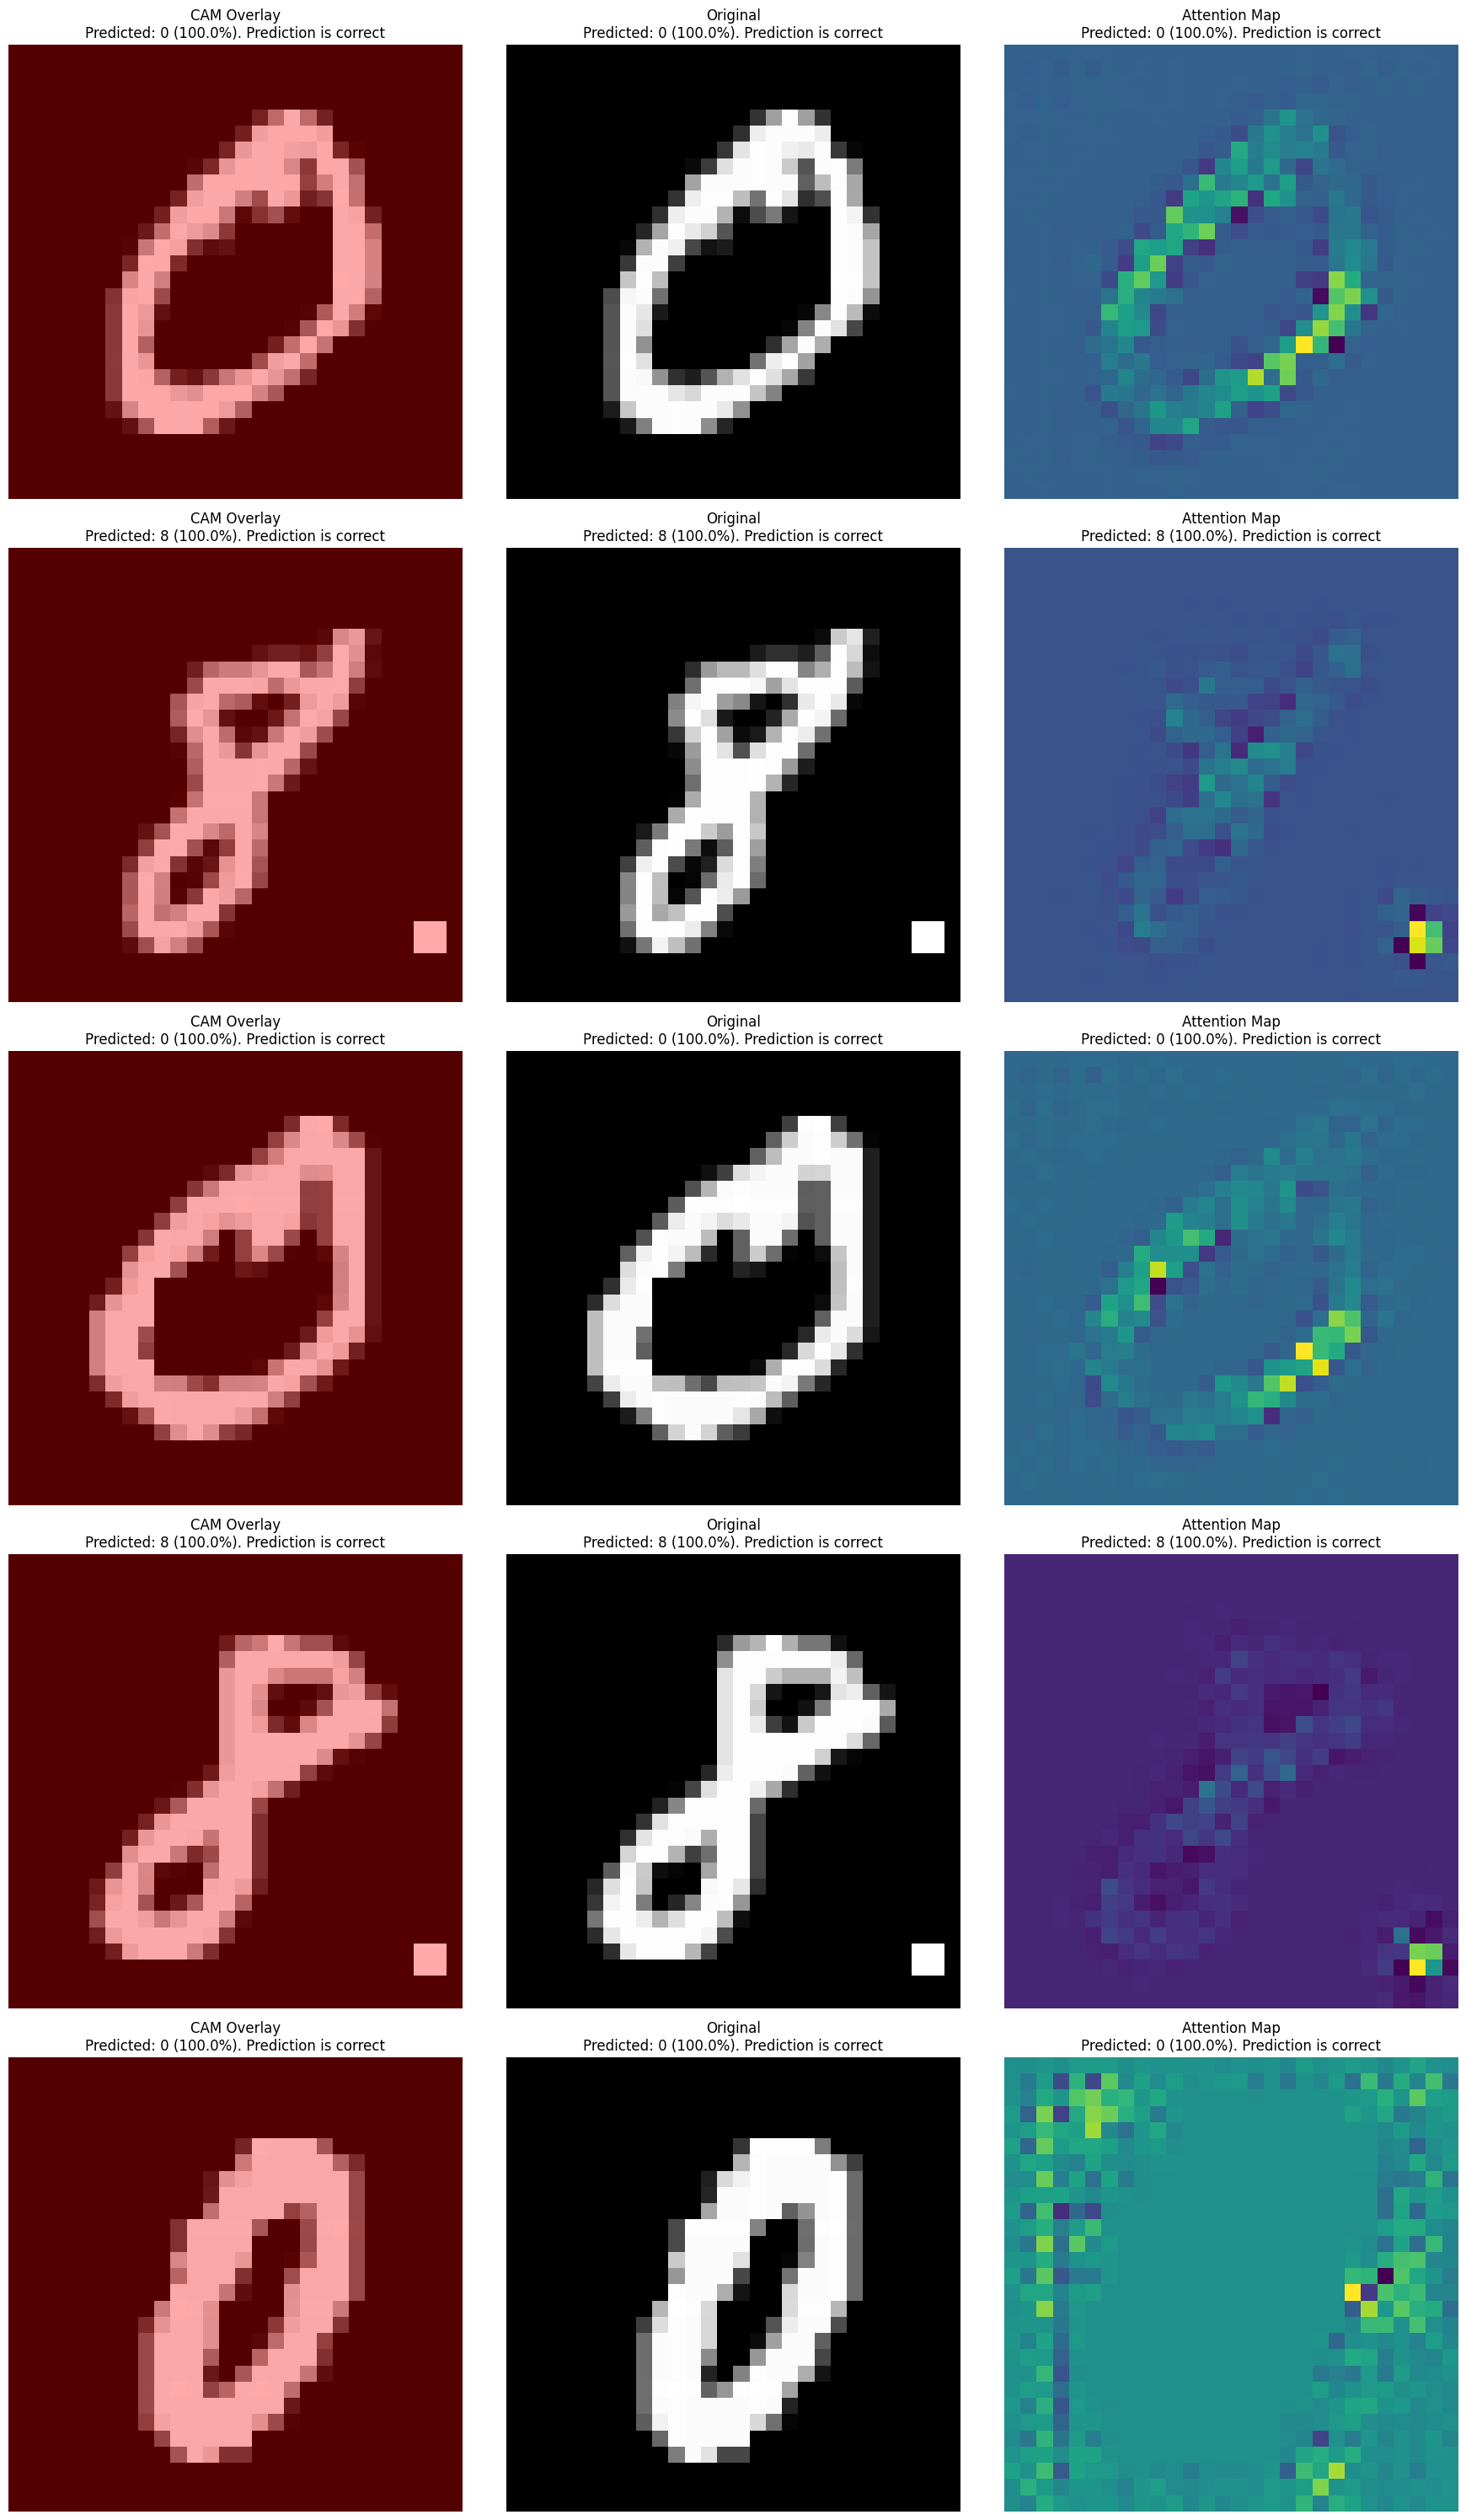

In [20]:
n_examples = 5

XILUtils.apply_and_show_gradcam(model_confounded, [model_confounded[3]], n_examples, misleading_ds_train_wo_binary_masks, num_classes, labels, plt,
                                shuffle_ds=False, batch_num=0, device=device, guided_backprop=True)

### Test the model on the test set


Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.]
Predicted target: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.] with 100.000% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000]
Predicted target: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.] with 96.733% certainty. Correct? False

Example 2:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.]
Predicted target: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.] with 100.000% certainty. Correct? True

Example 3:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000]
Predicted target: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000] with 87.607% certainty. Correct? True

Example 4:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000]
Predicted ta

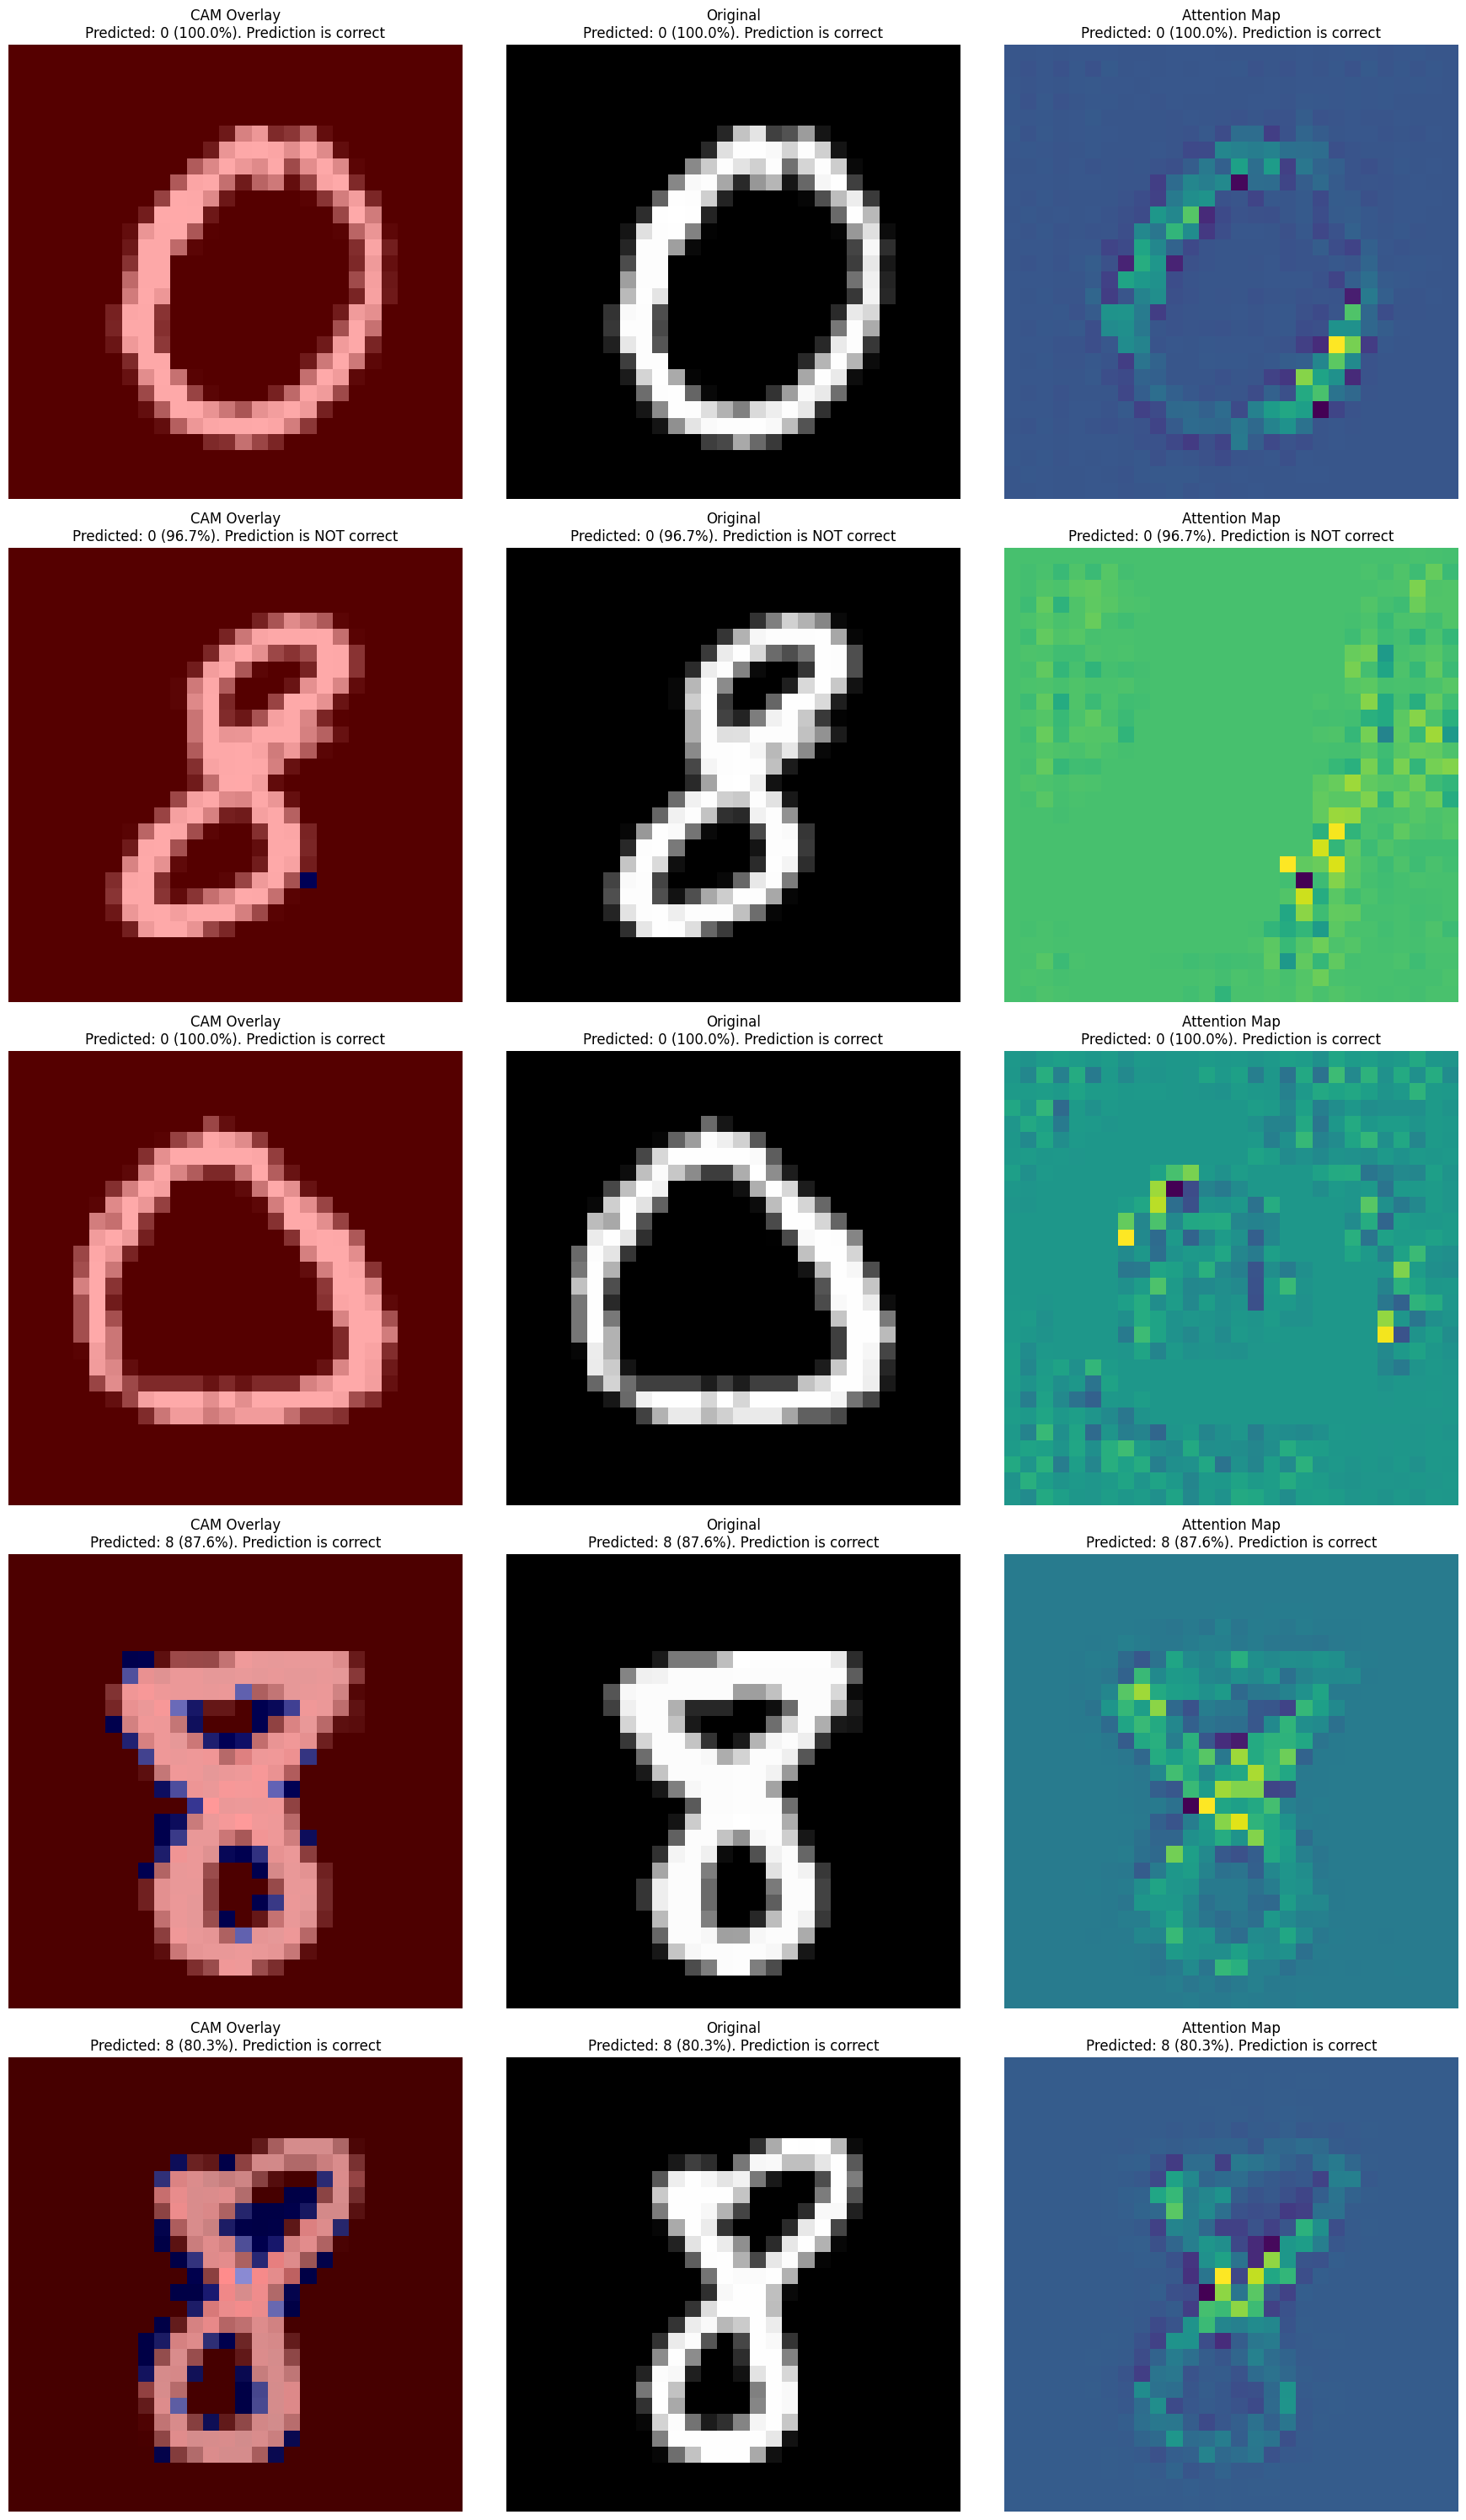

In [21]:
n_examples = 5

XILUtils.apply_and_show_gradcam(model_confounded, [model_confounded[3]], n_examples, ds_test, num_classes, labels, plt,
                                shuffle_ds=False, batch_num=2, device=device, guided_backprop=True)


## Create CE dataset
- [ ] Vary on the number of counterexamples
- [ ] Try out every strategy. Expected order of strategy perfomance:
    1. Alternative Value (As we always set it to zeros, which should be)
    2. Substitution Strategy
    3. Random Strategy

Maybe a good idea would be to set some certainty threshold (e.g. 95%), so that we would have benchmark for the strategies.

- [ ] go for the samples with lowest certainty (Paper says "$SelectQuery(f, U)$ for selecting an informative instance $x \in U$ based on the current model $f$". Definition of __Informative instance__ is not provided, although a simmilar thing is mentioned - "the query instances are chosen to be as informative as possible, typically by maximizing some informativeness criterion, such as the expected model improvement [ 28 ] or practical approximations thereof.")

Paper suggests that model should be learnt on Dataset = Old_dataset + counterexamples (original sample __included__). Maybe finetunning also gives positive result, maybe even superior?

Paper also talks about mixing Supervised and Unsupervised learning with more weight on the last one. Maybe we should do the same?

In [22]:
threshold = 0.98

Sort samples by certainty ascending

In [23]:
# evaluate train set
model_conf = CNNTwoConv(num_classes, device)
model_conf.load_state_dict(model_confounded.state_dict())
model_conf.eval()
samples = []
predicted = []
unshuffled_train_dl = DataLoader(misleading_ds_train_wo_binary_masks, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(unshuffled_train_dl):
        # ignore zeros
        mask = (y_batch == label_translation["eight"]).all(dim=1, keepdim=False)
        x_eights, t_eights = x_batch[mask], y_batch[mask]
        
        samples += x_eights
        predicted += model_conf(x_eights)



In [24]:
# sort by certainty
predicted_certainty = torch.stack(predicted, dim=0)[:, 0]
samples_all = torch.stack(samples, dim=0)
indices = torch.argsort(predicted_certainty, dim=0)


In [25]:
# Now create counterexamples for the most uncertain one. Sounds like bullshit, because I expected samples to come from test set, not train set. So not sure that this strategy is good

In [26]:
from src.caipi import RandomStrategy, SubstitutionStrategy, AlternativeValueStrategy, MarginalizedSubstitutionStrategy
# Initialise strategies

random_strategy = RandomStrategy(0., 1., torch.float32)
substitution_strategy = SubstitutionStrategy(inputs, targets)
marginalized_substitution_strategy = MarginalizedSubstitutionStrategy(inputs, targets) 
alternative_value_strategy = AlternativeValueStrategy(torch.zeros(image_shape, device=device), image_shape)


In [27]:
import itertools
parameters_grid = {
    "ce_num": [1, 2, 3, 4, 5],
    "strategy": [random_strategy, substitution_strategy, marginalized_substitution_strategy, alternative_value_strategy],
}

combinations = list(itertools.product(*parameters_grid.values()))


# train_evaluate()
# 
# def grid_search()

My prediction is that it will take too many epochs, because train_dataset is big and for every epoch we only examine one informative instance

In [28]:
num_of_instances = 1
lr = 1e-3

def get_informative_instance(targets, num_of_instances):
    # just take some random eight
    eight = label_translation["eight"]
    indices = (targets == eight).all(dim=1)
    # take a random eight
    indices = torch.randint(high=indices.size(0), size=(num_of_instances,))
    return indices

import json
from pathlib import Path

def save_info_to_json(filename: Path, info: dict):
    # Ensure the parent directory exists
    filename.parent.mkdir(parents=True, exist_ok=True)

    # Write the info dictionary to the file as JSON
    with filename.open('w', encoding='utf-8') as f:
        json.dump(info, f, indent=2, ensure_ascii=False)

def grid_search(filename: Path):
    misleading_data = misleading_ds_train.data
    misleading_labels = misleading_ds_train.labels
    misleading_binary_masks = misleading_ds_train.binary_masks
    info_dictionary = []
    for ce_num, strategy in combinations:
        print(f"Checking out {ce_num=}, {strategy=}")
        grid_model = CNNTwoConv(num_classes, device)
        grid_model.load_state_dict(model_confounded.state_dict())
        adam_optimizer = Adam(grid_model.parameters(), lr=lr)
        accuracy = evaluate(grid_model, test_dataloader, loss, verbose=False)
        
        current_run_info = {f"{ce_num=}": {
            f"{strategy}": {}
        }}
        current_data = misleading_data.clone()
        current_labels = misleading_labels.clone()
        current_binary_masks = misleading_binary_masks.clone()
        epoch = 1
        while accuracy < threshold:
            # take some input
            indices = get_informative_instance(current_labels, num_of_instances)
            informative_instances = current_data[indices]
            assert len(informative_instances.shape) == 4
            # predict input = prediction
            grid_model.eval()
            with torch.no_grad():
                prediction = grid_model(informative_instances)
            # get target, explanation
            informative_targets = current_labels[indices].unsqueeze(0)
            informative_binary_masks = current_binary_masks[indices].unsqueeze(0)
            explanation = XILUtils.create_explanation(informative_instances, informative_binary_masks, model=grid_model, device=device, target_layers=grid_model[3])
            # create counterexamples
            counterexamples = to_counter_examples_2d_pic(strategy, informative_instances, explanation, ce_num, target=label_translation["eight"])
            # populate dataset with new data
            current_data = torch.vstack((current_data, counterexamples))
            current_labels = torch.vstack((current_labels, (informative_targets.repeat_interleave(ce_num, dim=1))))
            # TODO: check if it is in correct shape, in correct order
            current_binary_masks = torch.vstack((current_binary_masks, informative_binary_masks.repeat_interleave(ce_num, dim=1)))
            # fit
            grid_train_dl = DataLoader(TensorDataset(current_data, current_labels), batch_size=batch_size, shuffle=True)
            train(grid_model, grid_train_dl, adam_optimizer, loss, verbose=False)
            # evaluate accuracy
            acc, avg_loss = evaluate(grid_model, test_dataloader, loss, verbose=False)
            current_run_info[f"{ce_num=}"][f"{strategy}"][epoch] = {"accuracy": acc, "average_loss": avg_loss}
            save_info_to_json(filename, current_run_info)
            # update epoch
            epoch += 1
            
        break

In [29]:
print(substitution_strategy)

SubstitutionStrategy


In [53]:
test_batch_size = 10
example_dataloader = torch.utils.data.DataLoader(misleading_ds_train, batch_size=test_batch_size, shuffle=False)
x_it, y_it, R_it = next(iter(example_dataloader))
x_it, y_it, R_it = x_it.cpu(), y_it.cpu(), R_it.cpu()
model_on_cpu = model_confounded.cpu()

In [58]:

test = XILUtils.create_explanation(x_it, R_it, model=model_on_cpu, device="cpu", target_layers=[model_on_cpu[3]])
indices_test = (y_it.cpu() == torch.tensor([0, 1])).all(dim=1)

print(f"Test explanation looks like: {test}")
print(f"Eights are at {torch.arange(test_batch_size)[indices_test]}")


Test explanation looks like: tensor[10, 1, 28, 28] n=7840 (31Kb) all_zeros
Eights are at tensor[5] i64 x∈[1, 9] μ=5.200 σ=3.194 [1, 3, 6, 7, 9]


In [59]:
guided_gradcam_explanation = XILUtils.guided_gradcam_explain(x_it, model_on_cpu, "cpu", target_layers=[model_on_cpu[3]])
XILUtils.create_explanation(x_it, R_it, model=model_on_cpu, device="cpu", target_layers=[model_on_cpu[3]])


tensor[10, 1, 28, 28] n=7840 (31Kb) all_zeros

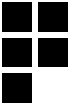

In [31]:
test[indices_test].repeat((1, 3, 1, 1)).rgb

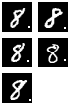

In [32]:

x_it[indices_test].repeat((1, 3, 1, 1)).rgb
